In [46]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2.ok')

Assignment: proj2
OK, version v1.13.11



# Project 2: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: Sunday 11/24/19, 11:59PM

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *Ryan Nuqui, Mikee Martin, Kim Chua*

## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
We've tried our best to filter the data for anything blatantly offensive as best as we can, but unfortunately there may still be some examples you may find in poor taste. If you encounter these examples and believe it is inappropriate for students, please let a TA know and we will try to remove it for future semesters. Thanks for your understanding!

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 1
1c | 2
2 | 3
3a | 2
3b | 2
4 | 2
5 | 2
6a | 1
6b | 1
6c | 2
6d | 2
6e | 1
6f | 3
7 | 6
8 | 6
9 | 3
10 | 15
Total | 55

# Part I - Initial Analysis

In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [48]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Sat Nov 23 15:07:06 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Sat Nov 23 15:07:08 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [49]:
original_training_data['subject'].fillna("", inplace = True) 

In [50]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [51]:
#original_training_data.query("spam == 0").iloc[0]
original_training_data.iloc[0]['email']

'url: http://boingboing.net/#85534171\n date: not supplied\n \n arts and letters daily, a wonderful and dense blog, has folded up its tent due \n to the bankruptcy of its parent company. a&l daily will be auctioned off by the \n receivers. link[1] discuss[2] (_thanks, misha!_)\n \n [1] http://www.aldaily.com/\n [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf\n \n \n'

In [52]:
first_ham = original_training_data.query("spam == 0").iloc[0]['email']
first_spam = original_training_data.query("spam == 1").iloc[0]['email']
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [53]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

*The ham email is an informative text, discussing news about a blog that's shutting down. It contains strings like a link to an external news site, a thanks to someone, etc. On the other hand, the spam email contains words with positive connontations like 'guaranteed', 'simply', 'increase' and looks to be selling a product. It also beckons the reader to come and see how it works. The distinguishing factors appears to be vocabulary used and overall tone of an email to classify it as spam or not. THe spam email also contains html tags while the ham is all in plain text.*

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [54]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [55]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for i in texts:
        nums = []
        for word in words:
            if word in i:
                nums.append(1)
            else:
                nums.append(0)
        indicator_array.append(nums)
    indicator_array = np.array(indicator_array)
    return indicator_array

In [56]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [57]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

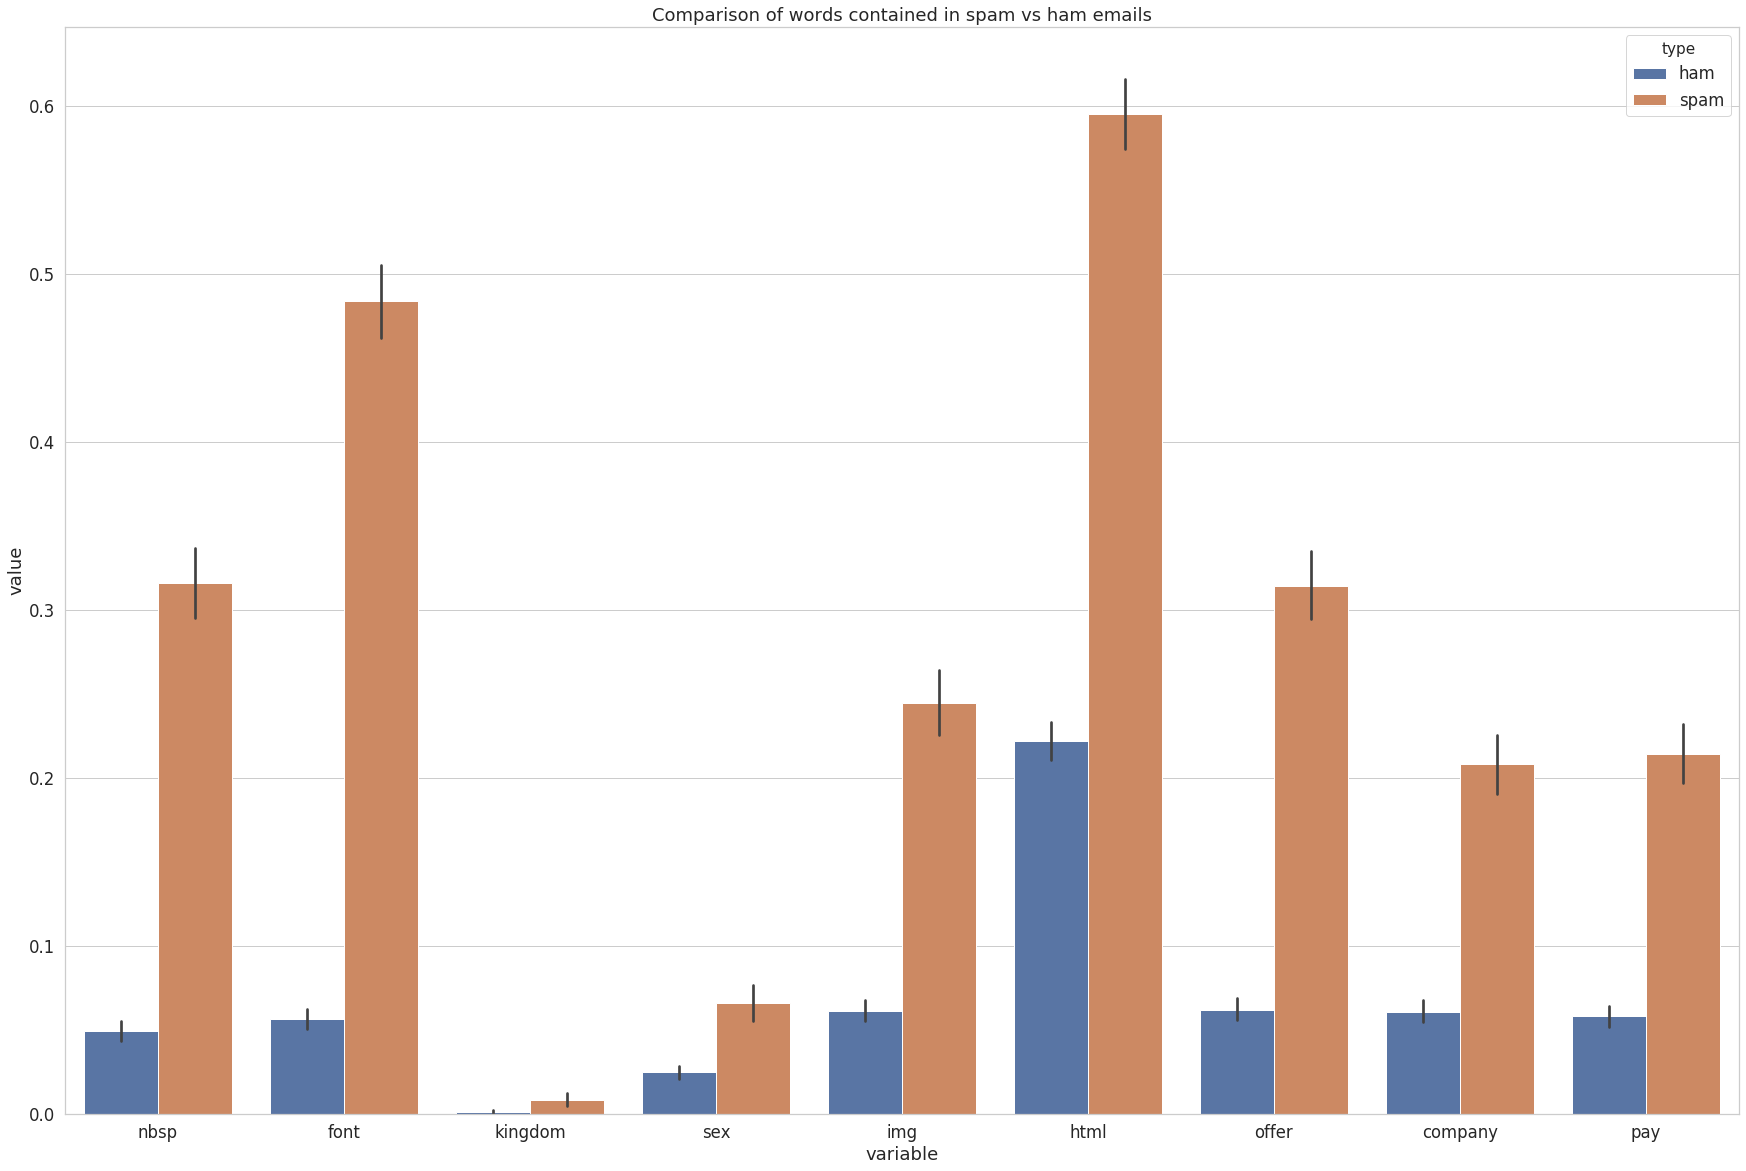

In [58]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

words = ['nbsp', 'font', 'kingdom', 'sex', 'img', 'html', 'offer', 'company', 'pay']
text = train['email']

testing = pd.DataFrame(words_in_texts(words, text), columns = words)
testing2 = pd.concat([train, testing], axis=1)
testing2 = testing2.drop(['id', 'subject', 'email'], axis=1)
testing2 = testing2.melt('spam')
testing2['spam'] = testing2['spam'].replace(0, 'ham')
testing2['spam'] = testing2['spam'].replace(1, 'spam')
testing2.columns = ['type', 'variable', 'value']

plt.figure(figsize=(30, 20))
plt.title('Comparison of words contained in spam vs ham emails')
sns.barplot(data=testing2, x = 'variable', y = 'value', hue = 'type')

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")


### Question 3b

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

Text(0, 0.5, 'Distribution')

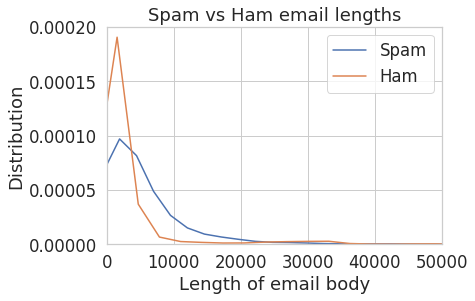

In [59]:
spam_train = train[train['spam'] == 1]
ham_train = train[train['spam'] == 0]

sns.distplot([len(email) for email in spam_train.email], label='Spam', hist=None)
sns.distplot([len(email) for email in ham_train.email], label='Ham', hist=None)
plt.xlim(0, 50000)
plt.title('Spam vs Ham email lengths')
plt.xlabel('Length of email body')
plt.ylabel('Distribution')

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [60]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [61]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [62]:
import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression

model = lm.LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train)

training_accuracy = np.mean(Y_pred == Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [63]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [64]:
zero_predictor_fp = 0
zero_predictor_fn = 1918

In [65]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [66]:
zero_predictor_acc = sum(Y_train == 0) / len(Y_train)
zero_predictor_recall = 0

zero_predictor_acc

0.7447091707706642

In [67]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

*The false positives in 6a mean the number of emails that the classifier flagged as spam but were actually ham (0 since it classified all as ham). The false negatives mean the number of emails that the classifier flagged as ham but were actually spam (1918). The accuracy indicates the percentage of all emails that the classifier classified correctly. The recall is an indicator of how many spam emails the classifier found out of the total number of spam emails (0 since the classifier predicted all emails to be ham.) These values are important to gauge the real effectiveness of a given classifier. We observe false positives and false negatives because in some cases it is important to minimize one or both. For example, it isn't terrible to give a false positive for a cancer screening since they could just follow it up with another test, but on the other hand, a false negative cancer screening could prove fatal. We observe accuracy because it is a general measurement of how right the predicitions are, while recall is a general measurement of how good the classifier is at just finding what they are filtering for.

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [68]:
def accuracy(actual, pred):
    return np.mean(actual == pred)

def precision(actual, pred):
    tp = sum((actual == pred) & (actual == 1))
    tn = sum((actual == pred) & (actual == 0))
    fp = sum((actual != pred) & (actual == 0))
    fn = sum((actual != pred) & (actual == 1))
    
    return tp / (tp + fp)

def recall(actual, pred):
    tp = sum((actual == pred) & (actual == 1))
    tn = sum((actual == pred) & (actual == 0))
    fp = sum((actual != pred) & (actual == 0))
    fn = sum((actual != pred) & (actual == 1))
    
    return tp / (tp + fn)

def far(actual, pred):
    tp = sum((actual == pred) & (actual == 1))
    tn = sum((actual == pred) & (actual == 0))
    fp = sum((actual != pred) & (actual == 0))
    fn = sum((actual != pred) & (actual == 1))
    
    return fp / (fp + tn)

Y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
logistic_predictor_precision = precision(Y_train, Y_pred)
logistic_predictor_recall = recall(Y_train, Y_pred)
logistic_predictor_far = far(Y_train, Y_pred)

print(logistic_predictor_precision)

print(logistic_predictor_recall)
print(logistic_predictor_far)

0.6422287390029325
0.11418143899895725
0.021805183199285077


In [70]:
ok.grade("q6d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

*When using the logistic regression classifier from Question 5, there are far more false negatives than false positives due to the much higher rate of precision vs. recall. Precision penalizes false positives and recall penalizes false negatives.*

### Question 6f

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

1. In terms of just accuracy, it's very close, with the Q5 classifier having 75.6% accuracy and the 0 classifier 74.5% accuracy. However, there are other ways to measure how good a model is.
2. One reason that this classifier is performing poorly is that the words given appear at a similar proportion in both categories and thus not the best possible indicator of whether or not an email is spam or ham.
3. I would rather have the classifier from Question 5 because although they perform similarly accuracy-wise, the Q5 classifier performs better in other metrics, like precision. The 0 classifier has an undefined precision (0/0) while Q5 has a 64% precision. Neither are great numbers, but one is obviously better than the other.


# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

**Kaggle limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on the entire set when submitting to Kaggle (the accuracy that will determine your score for question 10).

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

In [71]:
def n_upper_chars(string):
    return sum(map(str.isupper, string))

def bigger_than_20(list):
    if list > 0.20:
        return 1
    else:
        return 0

In [72]:
from collections import Counter
text = " ".join(email for email in spam_train.subject)
split_it = text.split()
#split_it = remove_stop_words(split_it)
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

Counter = Counter(split_it)
most_occur = Counter.most_common(1000)


def remove_stop_words(list):
    new_list = []
    for i in list:
        if i in stop_words:
            break
        else: 
            new_list.append(i)
    return new_list
            
most_occur

[('Subject:', 1918),
 ('for', 151),
 ('Your', 143),
 ('to', 134),
 ('your', 124),
 ('a', 119),
 ('the', 112),
 ('-', 110),
 ('you', 106),
 ('and', 78),
 ('of', 76),
 ('Free', 75),
 ('ADV:', 67),
 ('on', 65),
 ('Re:', 62),
 ('[ILUG]', 62),
 ('&', 54),
 ('in', 54),
 ('The', 53),
 ('!', 49),
 ('FREE', 48),
 ('You', 47),
 ('Get', 47),
 ('is', 44),
 ('with', 42),
 ('YOUR', 39),
 ('No', 36),
 ('A', 36),
 ('Mortgage', 33),
 ('this', 30),
 ('30', 30),
 ('Life', 29),
 ('are', 29),
 ('Best', 29),
 ('per', 28),
 ('from', 28),
 ('Rates', 27),
 ('me', 26),
 ('[ILUG-Social]', 26),
 ('Business', 25),
 ('Low', 24),
 ('rates', 24),
 ('Fw:', 23),
 ('I', 23),
 ('Insurance', 23),
 ('at', 23),
 ('2002', 23),
 ('Save', 23),
 ('Home', 22),
 ('Money', 22),
 ('it', 22),
 ('Make', 22),
 ('Email', 21),
 ('have', 21),
 ('SYSTEMWORKS', 21),
 ('Viagra', 20),
 ('Here', 20),
 ('get', 20),
 ('CLEARANCE', 20),
 ('year', 19),
 ('only', 19),
 ('New', 19),
 ('Quote', 19),
 ('inkjet', 18),
 ('cartridges', 18),
 ('that', 18

In [73]:
from collections import Counter
text = " ".join(email for email in ham_train.subject)
split_it = text.split()
#split_it = remove_stop_words(split_it)
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

Counter = Counter(split_it)
most_occur = Counter.most_common(1000)


def remove_stop_words(list):
    new_list = []
    for i in list:
        if i in stop_words:
            break
        else: 
            new_list.append(i)
    return new_list
            
most_occur

[('Subject:', 5593),
 ('Re:', 2651),
 ('the', 565),
 ('[ILUG]', 519),
 ('for', 507),
 ('to', 435),
 ('of', 363),
 ('RE:', 345),
 ('a', 290),
 ('on', 277),
 ('in', 276),
 ('[SAtalk]', 251),
 ('[Razor-users]', 244),
 ('and', 236),
 ('[Spambayes]', 228),
 ('with', 214),
 ('The', 214),
 ('[zzzzteana]', 182),
 ('is', 169),
 ('(was', 140),
 ('-', 126),
 ('[SAdev]', 122),
 ('from', 113),
 ('New', 110),
 ('[use', 99),
 ('Perl]', 99),
 ('new', 96),
 ('Selling', 89),
 ('Bliss', 89),
 ('Wedded', 87),
 ('Ouch...)', 86),
 ('spam', 83),
 ('A', 82),
 ('Razor', 76),
 ('Re[2]:', 69),
 ('Headlines', 66),
 ('8', 64),
 ('apt', 62),
 ('--', 58),
 ('message', 58),
 ('How', 57),
 ('test', 57),
 ('Review', 56),
 ('Java', 55),
 ('Stories', 54),
 ('Sequences', 52),
 ('Window', 52),
 ('an', 50),
 ('?', 50),
 ('use', 49),
 ('[Bug', 48),
 ('no', 48),
 ('[Lockergnome', 48),
 ('Deployment', 47),
 ('sets?', 47),
 ('kiddies', 47),
 ('at', 45),
 ('Linux', 45),
 ('ALSA', 45),
 ('problems', 44),
 ('problem', 44),
 ('Glob

In [74]:
from collections import Counter
text = " ".join(email for email in spam_train.email)
split_it = text.split()

Counter = Counter(split_it)
most_occur = Counter.most_common(100)

            
most_occur

[('the', 20313),
 ('to', 18876),
 ('and', 14106),
 ('of', 12525),
 ('you', 11580),
 ('a', 9483),
 ('=', 9228),
 ('for', 8022),
 ('your', 8014),
 ('<td', 7805),
 ('in', 7476),
 ('this', 6741),
 ('is', 6627),
 ('</tr>', 4631),
 ('i', 3958),
 ('with', 3930),
 ('or', 3901),
 ('that', 3854),
 ('on', 3820),
 ('are', 3719),
 ('be', 3679),
 ('<tr>', 3627),
 ('<font', 3478),
 ('will', 3351),
 ('<br>', 3344),
 ('our', 3224),
 ('from', 3194),
 ('we', 3093),
 ('have', 3071),
 ('helvetica,', 3054),
 ('not', 2943),
 ('-', 2912),
 ('it', 2865),
 ('as', 2729),
 ('</td>', 2675),
 ('<table', 2529),
 ('<p', 2475),
 ('if', 2416),
 ('by', 2388),
 ('email', 2367),
 ('all', 2220),
 ('<a', 2210),
 ('can', 2204),
 ('sans-serif"', 1922),
 ('</table>', 1904),
 ('at', 1871),
 ('free', 1788),
 ('no', 1744),
 ('my', 1741),
 ('arial,', 1695),
 ('<tr>=20', 1685),
 ('an', 1684),
 ('do', 1614),
 ('please', 1583),
 ('get', 1575),
 ('out', 1552),
 ('more', 1523),
 ('new', 1458),
 ('one', 1413),
 ('<div', 1302),
 ('any', 

In [75]:
from collections import Counter
text = " ".join(email for email in ham_train.email)
split_it = text.split()
#split_it = remove_stop_words(split_it)
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

Counter = Counter(split_it)
most_occur_2 = Counter.most_common(1000)


def remove_stop_words(list):
    new_list = []
    for i in list:
        if i in stop_words:
            break
        else: 
            new_list.append(i)
    return new_list
            
most_occur_2

[('the', 64331),
 ('>', 47992),
 ('to', 38625),
 ('a', 29739),
 ('and', 29537),
 ('of', 29008),
 ('in', 19831),
 ('is', 17363),
 ('for', 15678),
 ('that', 14852),
 ('i', 13480),
 ('on', 11501),
 ('it', 11444),
 ('<td', 10702),
 ('you', 10180),
 ('this', 9831),
 ('with', 9225),
 ('be', 7669),
 ('as', 7135),
 ('<a', 7088),
 ('are', 6881),
 ('have', 6774),
 ('from', 6525),
 ('not', 6347),
 ('or', 6127),
 ('at', 6075),
 ('your', 5886),
 ('but', 5827),
 ('-', 5489),
 ('=', 5469),
 ('by', 5228),
 ('if', 5143),
 ('an', 4931),
 ('was', 4659),
 ('can', 4509),
 ('-->', 4416),
 ('<!--', 4079),
 ('<table', 4070),
 ('all', 4007),
 ('they', 3942),
 ('will', 3934),
 ('width="1"', 3917),
 ('--', 3900),
 ('has', 3850),
 ('my', 3808),
 ('we', 3620),
 ('more', 3428),
 ('about', 3362),
 ('<font', 3342),
 ('so', 3224),
 ('list', 3151),
 ('just', 3150),
 ('border="0"', 3070),
 ('one', 3066),
 ('src="http://www.cnet.com/b.gif"', 2997),
 ('new', 2991),
 ('do', 2903),
 ('get', 2892),
 ('</tr>', 2845),
 ('<img'

In [76]:
!pip install wordcloud


You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [77]:
spam_train = train[train['spam'] == 1]
ham_train = train[train['spam'] == 0]

In [78]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

There are 1859482 words in the combination of all emails.


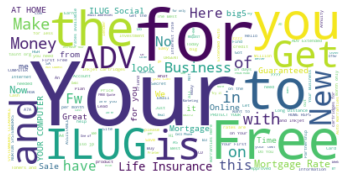

In [79]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(email for email in spam_train.subject)
text= text.replace('td', '')
print ("There are {} words in the combination of all emails.".format(len(split_it)))

# Create stopword list:
stopwords = ['Subject', 'Re']

#stopwords.update(['nbsp', 'size', '3d', 'sans', 'serif', '3d', 'height',
 #                'width', 'gif', 'color', 'helvetica', 'arial', 'font', 'face',
  #               'verdana', 'table', 'border', 'text', 'type', 'img', 'src', '3e',
   #              '3c'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 265136 words in the combination of all emails.


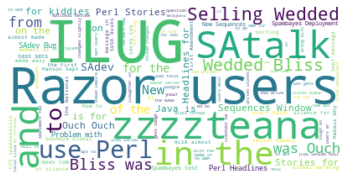

In [80]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(email for email in ham_train.subject)
text= text.replace('td', '')
print ("There are {} words in the combination of all emails.".format(len(text)))

# Create stopword list:
stopwords = ['Subject', 'Re']

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [81]:
def either_or(num):
    if num == 0:
        return 0
    else:
        return 1

In [82]:
test['email'] = test['email'].apply(remove_html_tags)
test['char_count_split'] = [len(email.split()) for email in test['email']]
test['char_count'] = [len(email) for email in test['email']]

test['sub_count'] = [len(str(subject)) for subject in test['subject']]

test['Your'] = [either_or(str(subject).count('Your')) for subject in test['subject']]
test['you'] = [either_or(str(subject).count('you')) for subject in test['subject']]
test['Free'] = [either_or(str(subject).count('Free')) for subject in test['subject']]

test['num_!'] = [email.count('!') for email in test['email']]
test['num_!!!'] = [email.count('!!!') for email in test['email']]
test['num_?'] = [email.count('?') for email in test['email']]
test['please'] = [either_or(email.count('please')) for email in test['email']]
test['font'] = [either_or(email.count('font')) for email in test['email']]
test['nbsp'] = [either_or(email.count('nbsp')) for email in test['email']]
test['html'] = [email.count('html') for email in test['email']]
test['html_2'] = [either_or(email.count('html')) for email in test['email']]
test['receive'] = [either_or(email.count('receive')) for email in test['email']]
test['reply'] = [email.count('reply') for email in test['email']]
test['num_!_sq'] = [(email.count('!'))**2 for email in test['email']]
test['email_2'] = [email.count('email') for email in test['email']]
test['money'] = [email.count('money') for email in test['email']]
test['sex'] = [email.count('sex') for email in test['email']]
test['information'] = [email.count('information') for email in test['email']]
test['order'] = [either_or(email.count('order')) for email in test['email']]
test['just'] = [email.count('just') for email in test['email']]
test['mailing'] = [email.count('mailing') for email in test['email']]
test['offer'] = [either_or(email.count('offer')) for email in test['email']]
test['company'] = [either_or(email.count('company')) for email in test['email']]
test['pay'] = [email.count('pay') for email in test['email']]
test['simply'] = [either_or(email.count('simply')) for email in test['email']]
test['click'] = [either_or(email.count('click')) for email in test['email']]

test['src'] = [either_or(email.count('src')) for email in test['email']]
test['img'] = [email.count('img') for email in test['email']]
test['report'] = [either_or(email.count('report')) for email in test['email']]
test['need'] = [either_or(email.count('need')) for email in test['email']]
test['credit'] = [either_or(email.count('credit')) for email in test['email']]
test['insurance'] = [either_or(email.count('insurance')) for email in test['email']]
test['save'] = [either_or(email.count('save')) for email in test['email']]
test['dollars'] = [either_or(email.count('dollars')) for email in test['email']]
test['investment'] = [either_or(email.count('investment')) for email in test['email']]
test['buy'] = [either_or(email.count('investment')) for email in test['email']]
test['rates'] = [either_or(email.count('rates')) for email in test['email']]
test['offers'] = [either_or(email.count('offers')) for email in test['email']]
test['opportunity'] = [either_or(email.count('opportunity')) for email in test['email']]


test['price'] = [either_or(email.count('price')) for email in test['email']]
test['unsubscribe'] = [either_or(email.count('unsubscribe')) for email in test['email']]

test['FREE'] = [either_or(str(subject).count('FREE')) for subject in test['subject']]
test['Rates'] = [either_or(str(subject).count('Rates')) for subject in test['subject']]

test['kingdom'] = [either_or(email.count('kingdom')) for email in test['email']]
test['valuable'] = [either_or(email.count('valuable')) for email in test['email']]
test['qualify'] = [either_or(email.count('qualify')) for email in test['email']]

new_test = test.drop(['id', 'subject', 'email'], axis=1)
test

,id,subject,email,char_count_split,char_count,sub_count,Your,you,Free,num_!,...,rates,offers,opportunity,price,unsubscribe,FREE,Rates,kingdom,valuable,qualify
0,0,Subject: CERT Advisory CA-2002-21 Vulnerabilit...,\n \n -----begin pgp signed message-----\n \n ...,1423,11683,55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Subject: ADV: Affordable Life Insurance ddbfk\n,low-cost term-life insurance!\n save up to 70%...,99,773,46,0,0,0,7,...,1,0,0,0,1,0,0,0,0,0
2,2,Subject: CAREER OPPORTUNITY. WORK FROM HOME\n,------=_nextpart_000_00a0_03e30a1a.b1804b54\n ...,22,1067,45,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Subject: Marriage makes both sexes happy\n,"url: http://www.newsisfree.com/click/-3,848315...",24,193,41,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Subject: Re: [SAtalk] SA very slow (hangs?) on...,on thursday 29 august 2002 16:39 cet mike burg...,129,921,79,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,Subject: Re: Alsa/Redhat 8 compatability\n,"once upon a time, brian wrote :\n \n > \n > ...",228,1492,41,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
996,996,Subject: Re: Goodbye Global Warming\n,\n --]> a green once said that if the spotted ...,45,253,36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,997,Subject: Re: Entrepreneurs\n,"on fri, 23 aug 2002, robert harley wrote:\n \n...",97,620,27,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,998,Subject: Re: [ILUG] slashdot EW Dijkstra humor\n,jpl suggested:\n > recursion is only truely u...,112,791,47,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [83]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

In [84]:
train2 = train.copy()
train2

,id,subject,email,spam
7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0
6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0
6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0
4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0
5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0
...,...,...,...,...
5734,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""tp"" == tim peters <tim.one@comcast.net>...",0
5191,5191,Subject: Reach millions on the internet!!\n,"\n dear consumers, increase your business sale...",1
5390,5390,Subject: Facts about sex.\n,\n forwarded-by: flower\n \n did you know that...,0
860,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt...",0


In [85]:
email_array = ['please', 'font', 'nbsp', 'html', 'receive', 'reply', 'money', 'sex', 'information',
              'order', 'just', 'mailing', 'offer', 'company', 'pay', 'simply', 'click',
              'src', 'img', 'report', 'need', 'credit', 'insurance', 'save', 'dollars', 'investment',
              'buy', 'rates', 'offers', 'opportunity', 'price', 'unsubscribe', 'kingdom', 'valuable',
              'qualify']
subject_array = ['Your', 'you', 'Free', 'FREE', 'Rates']

#Shorthand function after compiling most effective features
def featurize(df, email_array, subject_array):
    
    df['email'] = df['email'].apply(remove_html_tags)
    
    df['char_count_split'] = [len(email.split()) for email in df['email']]
    df['char_count'] = [len(email) for email in df['email']]
    df['sub_count'] = [len(str(subject)) for subject in df['subject']]
    
    df['num_!'] = [email.count('!') for email in df['email']]
    df['num_!!!'] = [email.count('!!!') for email in df['email']]
    df['num_?'] = [email.count('?') for email in df['email']]
    df['num_!_sq'] = [(email.count('!'))**2 for email in df['email']]
    
    for word in email_array:
        df[word] = [either_or(email.count(word)) for email in df['email']]
    for word in subject_array:
        df[word] = [either_or(str(subject).count('Your')) for subject in train['subject']]
        
    return df

new_train2 = featurize(train2, email_array, subject_array)

In [86]:
new_train2 = new_train2.drop(['id', 'subject', 'email'], axis=1)
X_train_2 = new_train2.drop(['spam'], axis=1)

#new_train[['num_!', 'please', 'font', 'nbsp', 'num_!_sq', 'html', 'receive', 'num_?', 
#                      'num_?_sq', 'reply', 'receive_sq', 'char_count', 'sub_count', 'size', 'char_count_split',
#                     'num_.', 'email_2', 'free',]]

Y_train_2 = new_train2['spam']

model2 = LogisticRegression()
model2.fit(X_train_2, Y_train_2)

Y_pred = model2.predict(X_train_2)

training_accuracy = np.mean(Y_pred == Y_train_2)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9170770664182084


In [87]:
train['email'] = train['email'].apply(remove_html_tags)

train['char_count_split'] = [len(email.split()) for email in train['email']]
train['char_count'] = [len(email) for email in train['email']]
train['sub_count'] = [len(subject) for subject in train['subject']]

#train['your'] = [either_or(subject.count('your')) for subject in train['subject']]

train['Your'] = [either_or(subject.count('Your')) for subject in train['subject']]
train['you'] = [either_or(subject.count('you')) for subject in train['subject']]
train['Free'] = [either_or(subject.count('Free')) for subject in train['subject']]

#train['num_.'] = [email.count('.') for email in train['email']]

train['num_!'] = [email.count('!') for email in train['email']]
train['num_!!!'] = [email.count('!!!') for email in train['email']]
train['num_?'] = [email.count('?') for email in train['email']]
train['please'] = [either_or(email.count('please')) for email in train['email']]

#train['body'] = [email.count('body') for email in train['email']]

train['font'] = [either_or(email.count('font')) for email in train['email']]
train['nbsp'] = [either_or(email.count('nbsp')) for email in train['email']]
train['html'] = [email.count('html') for email in train['email']]
train['html_2'] = [either_or(email.count('html')) for email in train['email']]
train['receive'] = [either_or(email.count('receive')) for email in train['email']]
train['reply'] = [email.count('reply') for email in train['email']]

#train['size'] = [email.count('size') for email in train['email']]

train['num_!_sq'] = [(email.count('!'))**2 for email in train['email']]

#train['num_?_sq'] = [(email.count('?'))**2 for email in train['email']]
#train['receive_sq'] = [(email.count('receive'))**2 for email in train['email']]

train['email_2'] = [email.count('email') for email in train['email']]

#train['free'] = [email.count('free') for email in train['email']]
#train['send'] = [email.count('send') for email in train['email']]

train['money'] = [email.count('money') for email in train['email']]

#train['money'] = [either_or(email.count('money')) for email in train['email']]

train['sex'] = [email.count('sex') for email in train['email']]
train['information'] = [email.count('information') for email in train['email']]

#train['mailing'] = [email.count('mailing') for email in train['email']]

train['order'] = [either_or(email.count('order')) for email in train['email']]
train['just'] = [email.count('just') for email in train['email']]
train['mailing'] = [email.count('mailing') for email in train['email']]
train['offer'] = [either_or(email.count('offer')) for email in train['email']]
train['company'] = [either_or(email.count('company')) for email in train['email']]
train['pay'] = [email.count('pay') for email in train['email']]
train['simply'] = [either_or(email.count('simply')) for email in train['email']]
train['click'] = [either_or(email.count('click')) for email in train['email']]
#train['click_2'] = [email.count('click') for email in train['email']]
#train['time'] = [either_or(email.count('time')) for email in train['email']]


train['src'] = [either_or(email.count('src')) for email in train['email']]
train['img'] = [email.count('img') for email in train['email']]

train['report'] = [either_or(email.count('report')) for email in train['email']]

train['need'] = [either_or(email.count('need')) for email in train['email']]
#train['million'] = [either_or(email.count('million')) for email in train['email']]
#train['government'] = [either_or(email.count('government')) for email in train['email']]

train['credit'] = [either_or(email.count('credit')) for email in train['email']]
train['insurance'] = [either_or(email.count('insurance')) for email in train['email']]
train['save'] = [either_or(email.count('save')) for email in train['email']]
train['dollars'] = [either_or(email.count('dollars')) for email in train['email']]
train['investment'] = [either_or(email.count('investment')) for email in train['email']]

train['buy'] = [either_or(email.count('investment')) for email in train['email']]
train['rates'] = [either_or(email.count('rates')) for email in train['email']]
train['offers'] = [either_or(email.count('offers')) for email in train['email']]
train['opportunity'] = [either_or(email.count('opportunity')) for email in train['email']]


train['price'] = [either_or(email.count('price')) for email in train['email']]
train['unsubscribe'] = [either_or(email.count('unsubscribe')) for email in train['email']]


train['FREE'] = [either_or(subject.count('FREE')) for subject in train['subject']]
train['Rates'] = [either_or(subject.count('Rates')) for subject in train['subject']]


#train['sponsored'] = [either_or(email.count('sponsored')) for email in train['email']]

train['kingdom'] = [either_or(email.count('kingdom')) for email in train['email']]
train['valuable'] = [either_or(email.count('valuable')) for email in train['email']]

#train['upper'] = [bigger_than_20(n_upper_chars(subject) / (len(subject) + 1)) for subject in train.subject]


train['qualify'] = [either_or(email.count('qualify')) for email in train['email']]
#train['secret'] = [either_or(email.count('secret')) for email in train['email']]

new_train = train.drop(['id', 'subject', 'email'], axis=1)
new_train

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

,spam,char_count_split,char_count,sub_count,Your,you,Free,num_!,num_!!!,num_?,...,rates,offers,opportunity,price,unsubscribe,FREE,Rates,kingdom,valuable,qualify
7657,0,222,1641,37,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
6911,0,617,4713,42,0,0,0,0,0,11,...,0,0,0,0,0,0,0,0,0,0
6074,0,160,1322,54,0,0,0,3,0,7,...,0,0,0,0,0,0,0,0,0,0
4376,0,682,4435,73,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
5766,0,893,7891,52,0,0,0,2,0,10,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,59,444,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,1,978,7054,42,0,0,0,36,3,9,...,0,0,0,1,0,0,0,0,0,0
5390,0,279,1732,26,0,0,0,3,0,1,...,0,0,0,0,0,0,0,0,0,0
860,0,171,1074,52,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [99]:
X_train_2 = new_train.drop(['spam'], axis=1)

#new_train[['num_!', 'please', 'font', 'nbsp', 'num_!_sq', 'html', 'receive', 'num_?', 
#                      'num_?_sq', 'reply', 'receive_sq', 'char_count', 'sub_count', 'size', 'char_count_split',
#                     'num_.', 'email_2', 'free',]]

Y_train_2 = new_train['spam']

model2 = LogisticRegression()
model2.fit(X_train_2, Y_train_2)

Y_pred = model2.predict(X_train_2)

training_accuracy = np.mean(Y_pred == Y_train_2)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9241315053906562


In [100]:
test_pred = model2.predict(new_test)
test_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,

In [101]:
model = LogisticRegression()

list_features = []

train_copy = train.copy()
text = train_copy['email']
subject = train_copy['subject']

length = [len(email) for email in train_copy['email']]
word_count = [len(email.split()) for email in train_copy['email']]

words_exists = []
words_exists.append(['please', 'font', 'nbsp', 'html', 'receive', 'reply', 'money', 'sex', 'information', 'order',
                     'just', 'mailing', 'offer', 'company', 'pay', 'simply', 'click'])

words_counts = []
words_counts.append

words_subject = []
words_subject.append(['Your', 'your', 'you', 'free'])

for word in words_exists:
    features = pd.DataFrame(count_words_texts(word, text), columns = word)
    list_features.append(features)
    
    for words in words_counts:
        features = features.copy()
        all_words_counts = pd.DataFrame(count_words_texts(words, text))
        features = pd.concat([features, all_words_counts], axis = 1)
        list_features.append(features)
        
extra = []

for features in list_features:
    for words in words_subject:
        features = features.copy()
        all_subject_words = pd.DataFrame(words_in_texts(words, subject), columns = words)
        features = pd.concat([features, all_subject_words], axis = 1)
        extra.append(features)
        
list_features = list_features + extra

min_CEL_error = float('inf')
best_features = 0
Y_train = train_copy['spam']

for features in list_features:
    error = compute_CEL_error(model, features, Y_train)
    print(features.columns)
    print(error)
    print()
    
    if error < min_CEL_error:
        min_CEL_error = error
        best_features = features
        
print(best_features.columns)

TypeError: object of type 'int' has no len()

In [102]:
from sklearn.model_selection import KFold

def cel(y_obs, y_hat):
    return -np.mean(y_obs * np.log(y_hat) + (1 - y_obs) * np.log(1-y_hat))

def count_words_texts(words, texts):
    
    indicator_array = np.empty([len(texts), len(words)])
    for index in range(len(texts)):
        for word_index in range(len(words)):
            text = texts[index]
            word = words[word_index]
            indicator_array[index][word_index] = text.count(word)
            
    return indicator_array.astype(int)

def compute_CEL_error(model, X_train, Y_train):
   
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(X = split_X_train, y = split_Y_train)
        
        # Compute the RMSE on the validation split
        error = cel(split_Y_valid, model.predict(split_X_valid)[:, 1])


        validation_errors.append(error)
        
    return np.mean(validation_errors)

In [103]:
errors = []
for N in np.arange(10):
    print(f"Trying first {N} features")
    model2 = LogisticRegression()
    model2.fit(X_train_2, Y_train_2)
    
    # compute the cross validation error
    error = compute_CEL_error(model2, X_train_2.iloc[:, :N], Y_train)
    
    print("\tRMSE:", error)
    errors.append(error)

print(f"Best choice, use the first {best_num_features} features")

Trying first 0 features


ValueError: Found array with 0 feature(s) (shape=(5634, 0)) while a minimum of 1 is required.

In [104]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

In [105]:
from collections import Counter
text = " ".join(email for email in spam_train.email)
text2 = " ".join(email for email in ham_train.email)
split_it = text.split()
split_it_2 = text2.split()

Counter1 = Counter(split_it)
Counter2 = Counter(split_it_2)
most_occur = Counter1.most_common(1000)
most_occur2 = Counter2.most_common(150)

            
most_spam = [item[0] for item in most_occur]
most_ham = [item[0] for item in most_occur2]

def featurize(df, array):
    for word in array:
        df[word] = [either_or(str(email).count(word)) for email in train['email']]
    return df

yeet = featurize(train, most_spam)
best_yeet = yeet.drop(['id', 'subject', 'email', 'spam'], axis = 1)

yeet2 = featurize(yeet, most_ham)
best_yeet_2 = yeet2.drop(['id', 'subject', 'email', 'spam'], axis = 1)

best_yeet_2

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,the,to,and,of,you,a,=,for,your,<td,...,////////////////////////////////////////////////////////////////////////////,"src=""http://home.cnet.com/b.gif""","alt=""""","src=""http://www.zdnet.com/b.gif""",>>,wrote:,"height=""1""></td>",date:,"bgcolor=""#000000""><img","target=""_blank"""
7657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5766,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->
<!-- EXPORT TO PDF -->

1. One of the ways I used to find better features for my model was to compare the most used words in the spam emails vs. those of the ham emails. I then used the presence/count distinct words (that weren't stop words like "the" or "an") within the emails as additional features for my model. I utilized iterative improvement to test features that would improve the accuracy of the model on the test set. I then kept the features that improved the accuracy and dumped ones that would not. The process was all very heuristic-based.

2. One thing I tried that didn't work was to calculate the proportion of capital letters in the subject header as an indicator (since many spam email subjects are in ALL CAPS) Another thing I tried was to count the characters and words in the subject and body of the emails, which appeared to be a distinguishing feature. Another feature I tried that worked was to add weight to the number of !'s in the email body by adding another feature that squared the total number of !'s in the email body. 

3. Surprisingly, it's not easy to predict what features would immediately improve or worsen the model. In using existence of words like "sponsored" or "millions" (which I would expect to appear in spam emails like "THIS PRODUCT IS SPONSORED BY MILLIONS OF AMERICANS") as features, it worsened my model accuracy. However, using strings like "kingdom" or "src" greatly improved the accuracy of my model.

### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. Include

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

There are 877814 words in the combination of all spam email subject headers.


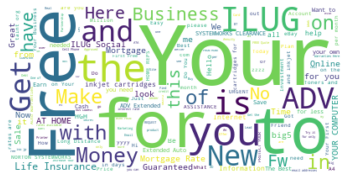

There are 265136 words in the combination of all ham email subject headers.


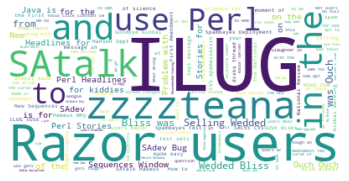

In [106]:
# Write your description (2-3 sentences) as a comment here:
#One type of visualization that I used to select features for my model was a wordcloud. The wordclouds I generated were able to
#to tell me which words were most often used between spam emails and ham emails. I then use the existence of these words in
#either email bodies or subjects as features for my model.

# Write the code to generate your visualization here:
text = " ".join(email for email in spam_train.subject)
text= text.replace('td', '')
print ("There are {} words in the combination of all spam email subject headers.".format(len(split_it)))

# Create stopword list:
stopwords = ['Subject', 'Re']

#stopwords.update(['nbsp', 'size', '3d', 'sans', 'serif', '3d', 'height',
 #                'width', 'gif', 'color', 'helvetica', 'arial', 'font', 'face',
  #               'verdana', 'table', 'border', 'text', 'type', 'img', 'src', '3e',
   #              '3c'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

text = " ".join(email for email in ham_train.subject)
text= text.replace('td', '')
print ("There are {} words in the combination of all ham email subject headers.".format(len(text)))

# Create stopword list:
stopwords = ['Subject', 'Re']

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Question 9: ROC Curve

In most cases we won't be able to get no false positives and no false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Kaggle). Refer to the Lecture 22 notebook or Section 17.7 of the course text to see how to plot an ROC curve.



<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

Text(0.5, 1.0, 'Spam Model ROC Curve')

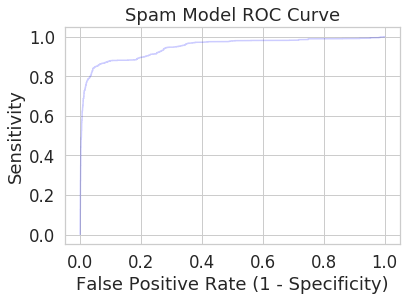

In [112]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

words_list_model_probabilities = model2.predict_proba(X_train_2)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(Y_train_2, words_list_model_probabilities, pos_label=1)

plt.step(false_positive_rate_values, sensitivity_values, color='blue', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Spam Model ROC Curve')

# Question 10: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your score for this question will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/c/ds100fa19

*The provided tests check that your predictions are in the correct format, but you must submit to Kaggle to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 15
-->

In [108]:
test_predictions = test_pred

In [109]:
ok.grade("q10");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



The following saves a file to submit to Kaggle.

In [110]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2019-11-26T00:58:55.csv.
You may now upload this CSV file to Kaggle for scoring.


# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 9 EXPORTED QUESTIONS -->

In [ ]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj2.ipynb', 'proj2.pdf')
ok.submit()

Generating PDF...
Saved proj2.pdf
